# 다중클래스 로지스틱 회귀 — Step-by-Step Tutorial

단층 Softmax 분류기의 순전파 → 손실 → 역전파 → 결정경계 변화를 **하나의 Toy Example**에서 단계별로 체험합니다.

| 개념 | 내용 |
|:---|:---|
| 구조 | $z_k = w_{k0} + w_{k1} x_1 + w_{k2} x_2$ |
| 활성함수 | $o_k = \text{softmax}(\mathbf{z})_k = \dfrac{e^{z_k}}{\sum_{q=1}^{C} e^{z_q}}$ |
| 손실함수 | Cross-Entropy: $\ell = -\sum_{k=1}^{C} y_k \log o_k$ |
| 그래디언트 | $\dfrac{\partial \ell}{\partial w_{ki}} = (o_k - y_k)\,x_i$ |
| Notation | $i$=입력, $k$=출력클래스, $n$=샘플, $q$=합산용 |

---
## Step 0: 라이브러리 & 기본 함수

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['figure.dpi'] = 130
plt.rcParams['font.size'] = 11

def softmax(z):
    """Numerically stable softmax"""
    e = np.exp(z - np.max(z, axis=-1, keepdims=True))
    return e / e.sum(axis=-1, keepdims=True)

print('준비 완료!')

준비 완료!


---
## Step 1: 데이터 & 초기 가중치

3개 클래스, 6개 샘플 ($x_1, x_2$ 2차원 입력 + bias $x_0=1$)

| $n$ | $x_1$ | $x_2$ | $y$ | 클래스 |
|:---:|:---:|:---:|:---:|:---|
| 1 | 1 | 1 | 0 | ● 빨강 |
| 2 | 2 | 0 | 0 | ● 빨강 |
| 3 | 0 | 3 | 1 | ● 파랑 |
| 4 | 1 | 4 | 1 | ● 파랑 |
| 5 | 4 | 1 | 2 | ● 초록 |
| 6 | 3 | 3 | 2 | ● 초록 |

In [2]:
# ── 데이터 정의 ──
X_raw = np.array([
    [1, 1],   # n=1, class 0
    [2, 0],   # n=2, class 0
    [0, 3],   # n=3, class 1
    [1, 4],   # n=4, class 1
    [4, 1],   # n=5, class 2
    [3, 3],   # n=6, class 2
])
y = np.array([0, 0, 1, 1, 2, 2])
N = len(y)   # 샘플 수
C = 3        # 클래스 수
d = 2        # 입력 차원

# Augmented X (bias x_0 = 1 추가)
X = np.column_stack([np.ones(N), X_raw])  # shape (6, 3)

# One-hot 인코딩
Y_oh = np.zeros((N, C))
for n in range(N):
    Y_oh[n, y[n]] = 1

# ── 초기 가중치 W: shape (C, d+1) = (3, 3) ──
# W[k] = [w_k0, w_k1, w_k2] → z_k = w_k0 + w_k1*x1 + w_k2*x2
W = np.array([
    [ 1., -1.,  0.],   # class 0: bias=1, x1 방향 음수
    [ 0.,  0.,  1.],   # class 1: x2 방향 양수
    [-1.,  1.,  0.],   # class 2: x1 방향 양수
])

rho = 0.1  # 학습률

print("데이터 & 초기 가중치")
print("=" * 50)
print(f"샘플 수: N={N}, 클래스 수: C={C}, 입력 차원: d={d}")
print(f"학습률: ρ = {rho}")
print()
for k in range(C):
    print(f"W_{k} = [{W[k,0]:+.0f}, {W[k,1]:+.0f}, {W[k,2]:+.0f}]")
    print(f"  → z_{k} = {W[k,0]:+.0f} + ({W[k,1]:+.0f})x₁ + ({W[k,2]:+.0f})x₂")

데이터 & 초기 가중치
샘플 수: N=6, 클래스 수: C=3, 입력 차원: d=2
학습률: ρ = 0.1

W_0 = [+1, -1, +0]
  → z_0 = +1 + (-1)x₁ + (+0)x₂
W_1 = [+0, +0, +1]
  → z_1 = +0 + (+0)x₁ + (+1)x₂
W_2 = [-1, +1, +0]
  → z_2 = -1 + (+1)x₁ + (+0)x₂


---
## Step 2: 데이터 시각화

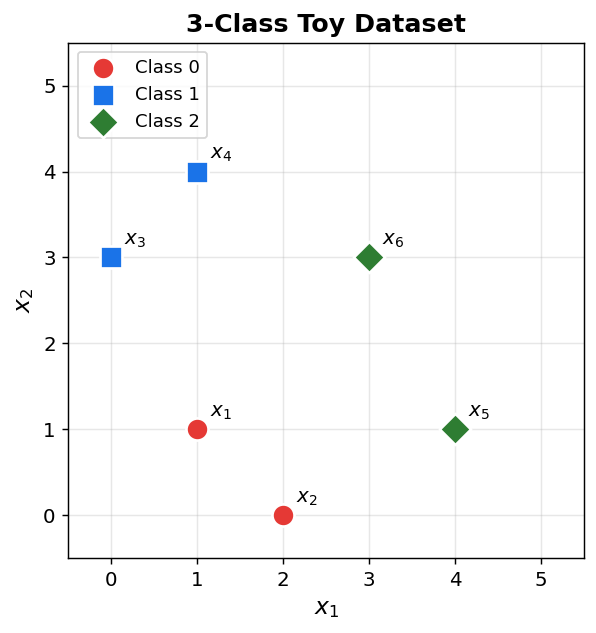

In [3]:
COLORS = ['r', 'b', 'g']  
MARKERS = ['o', 's', 'D']
CLASS_NAMES = ['Class 0', 'Class 1', 'Class 2']

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

for k in range(C):
    mask = y == k
    ax.scatter(X_raw[mask, 0], X_raw[mask, 1], c=COLORS[k], marker=MARKERS[k],
               s=150, edgecolors='white', linewidth=1.5, zorder=5, label=CLASS_NAMES[k])

# 라벨 추가
for n in range(N):
    ax.annotate(f'$x_{n+1}$', (X_raw[n,0]+0.15, X_raw[n,1]+0.15), fontsize=11, zorder=6)

ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax.set_title('3-Class Toy Dataset', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-0.5, 5.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Step 3: 순전파 (Forward Pass)

각 샘플에 대해:
1. **Pre-activation**: $z_k = \mathbf{w}_k^T \mathbf{x} = w_{k0} + w_{k1}x_1 + w_{k2}x_2$
2. **Softmax**: $o_k = \dfrac{e^{z_k}}{\sum_{q=1}^{C} e^{z_q}}$
3. **Prediction**: $\hat{y} = \arg\max_k \, o_k$

In [4]:
# ── Forward Pass ──
Z = X @ W.T      # shape (N, C) — 각 행: [z_0, z_1, z_2]
O = softmax(Z)    # shape (N, C) — 각 행: [o_0, o_1, o_2]
preds = np.argmax(O, axis=1)

print("순전파 결과")
print("=" * 90)
print(f"{'n':<4} {'(x1,x2)':<10} {'y':>3}  {'z_0':>7} {'z_1':>7} {'z_2':>7}  "
      f"{'o_0':>7} {'o_1':>7} {'o_2':>7}  {'pred':>4}  결과")
print("-" * 90)

n_mis = 0
for n in range(N):
    status = "✓ 정분류" if preds[n] == y[n] else "✗ 오분류"
    if preds[n] != y[n]: n_mis += 1
    print(f"{n+1:<4} ({int(X_raw[n,0])},{int(X_raw[n,1])})     {y[n]:>3}  "
          f"{Z[n,0]:>+7.2f} {Z[n,1]:>+7.2f} {Z[n,2]:>+7.2f}  "
          f"{O[n,0]:>7.4f} {O[n,1]:>7.4f} {O[n,2]:>7.4f}  "
          f"{preds[n]:>4}  {status}")

print("=" * 90)
print(f"오분류: {n_mis}/{N}개")

순전파 결과
n    (x1,x2)      y      z_0     z_1     z_2      o_0     o_1     o_2  pred  결과
------------------------------------------------------------------------------------------
1    (1,1)       0    +0.00   +1.00   +0.00   0.2119  0.5761  0.2119     1  ✗ 오분류
2    (2,0)       0    -1.00   +0.00   +1.00   0.0900  0.2447  0.6652     2  ✗ 오분류
3    (0,3)       1    +1.00   +3.00   -1.00   0.1173  0.8668  0.0159     1  ✓ 정분류
4    (1,4)       1    +0.00   +4.00   +0.00   0.0177  0.9647  0.0177     1  ✓ 정분류
5    (4,1)       2    -3.00   +1.00   +3.00   0.0022  0.1189  0.8789     2  ✓ 정분류
6    (3,3)       2    -2.00   +3.00   +2.00   0.0049  0.7275  0.2676     1  ✗ 오분류
오분류: 3/6개


---
## Step 4: Cross-Entropy 손실 계산

**단일 샘플 손실:**
$$\ell^{(n)} = -\sum_{k=1}^{C} y_k^{(n)} \log o_k^{(n)}$$

One-hot이므로 $y_k = 1$인 항만 남아서:
$$\ell^{(n)} = -\log o_{y^{(n)}}^{(n)}$$

**전체 비용:**
$$J = \sum_{n=1}^{N} \ell^{(n)}$$

In [5]:
# ── CE Loss ──
print("Cross-Entropy 손실")
print("=" * 60)
total_loss = 0
for n in range(N):
    o_true = O[n, y[n]]           # 정답 클래스의 softmax 확률
    loss_n = -np.log(o_true)
    total_loss += loss_n
    status = "✗" if preds[n] != y[n] else " "
    print(f"  n={n+1}: ℓ = -log(o_{y[n]}) = -log({o_true:.4f}) = {loss_n:.4f}  {status}")

print("-" * 60)
print(f"  J = Σℓ = {total_loss:.4f}")
print()
print("→ 오분류 샘플(n=1,2,6)의 손실이 크고, 정분류 샘플(n=3,4,5)의 손실이 작음")

Cross-Entropy 손실
  n=1: ℓ = -log(o_0) = -log(0.2119) = 1.5514  ✗
  n=2: ℓ = -log(o_0) = -log(0.0900) = 2.4076  ✗
  n=3: ℓ = -log(o_1) = -log(0.8668) = 0.1429   
  n=4: ℓ = -log(o_1) = -log(0.9647) = 0.0360   
  n=5: ℓ = -log(o_2) = -log(0.8789) = 0.1291   
  n=6: ℓ = -log(o_2) = -log(0.2676) = 1.3182  ✗
------------------------------------------------------------
  J = Σℓ = 5.5852

→ 오분류 샘플(n=1,2,6)의 손실이 크고, 정분류 샘플(n=3,4,5)의 손실이 작음


---
## Step 5: 오차 계산 ($o_k - y_k$)

Cross-Entropy + Softmax의 핵심 결과:

$$\frac{\partial \ell}{\partial w_{ki}} = (o_k - y_k)\,x_i$$

Binary 로지스틱 회귀의 $(\sigma - y)x_i$와 **동일한 형태**입니다!

In [6]:
# ── Error: O - Y ──
E = O - Y_oh   # shape (N, C)

print("오차 (o_k - y_k) per sample")
print("=" * 65)
print(f"{'n':<4} {'y':>3}  {'o_0-y_0':>10} {'o_1-y_1':>10} {'o_2-y_2':>10}  해석")
print("-" * 65)
for n in range(N):
    # 해석 만들기
    max_err_idx = np.argmax(np.abs(E[n]))
    if preds[n] != y[n]:
        interp = f"정답 class {y[n]} 확률 ↑ 필요"
    else:
        interp = f"이미 정분류 (미세 조정)"
    
    print(f"{n+1:<4} {y[n]:>3}  {E[n,0]:>+10.4f} {E[n,1]:>+10.4f} {E[n,2]:>+10.4f}  {interp}")
print("=" * 65)
print()
print("→ 오차가 음수: 해당 클래스 확률을 높여야 함")
print("→ 오차가 양수: 해당 클래스 확률을 낮춰야 함")
print("→ 각 행의 합 = 0 (softmax 확률의 합 = 1이므로)")

오차 (o_k - y_k) per sample
n      y     o_0-y_0    o_1-y_1    o_2-y_2  해석
-----------------------------------------------------------------
1      0     -0.7881    +0.5761    +0.2119  정답 class 0 확률 ↑ 필요
2      0     -0.9100    +0.2447    +0.6652  정답 class 0 확률 ↑ 필요
3      1     +0.1173    -0.1332    +0.0159  이미 정분류 (미세 조정)
4      1     +0.0177    -0.0353    +0.0177  이미 정분류 (미세 조정)
5      2     +0.0022    +0.1189    -0.1211  이미 정분류 (미세 조정)
6      2     +0.0049    +0.7275    -0.7324  정답 class 2 확률 ↑ 필요

→ 오차가 음수: 해당 클래스 확률을 높여야 함
→ 오차가 양수: 해당 클래스 확률을 낮춰야 함
→ 각 행의 합 = 0 (softmax 확률의 합 = 1이므로)


---
## Step 6: 배치 그래디언트 계산

$$\frac{\partial J}{\partial w_{ki}} = \sum_{n=1}^{N} (o_k^{(n)} - y_k^{(n)}) \, x_i^{(n)}$$

매트릭스 형태:
$$\nabla_{\mathbf{W}} J = (\mathbf{O} - \mathbf{Y})^T \mathbf{X}$$

In [7]:
# ── Gradient: dJ/dW ──
dW = E.T @ X    # shape (C, d+1) = (3, 3)

print("그래디언트 dJ/dW = (O-Y)^T X")
print("=" * 55)
print(f"{'':>10} {'dw_k0':>10} {'dw_k1':>10} {'dw_k2':>10}")
print("-" * 55)
for k in range(C):
    print(f"class {k}:   {dW[k,0]:>+10.4f} {dW[k,1]:>+10.4f} {dW[k,2]:>+10.4f}")
print("=" * 55)
print()
print("해석:")
print(f"  class 0: dw_00={dW[0,0]:+.4f} (bias ↓) → class 0 전반적으로 확률 올려야")
print(f"  class 1: dw_11={dW[1,1]:+.4f} (x1 계수 ↑) → class 1이 x1 큰 곳에서 과하게 활성화")
print(f"  class 2: dw_22={dW[2,2]:+.4f} (x2 계수 ↓) → class 2가 x2 큰 곳에서 더 활성화되어야")

그래디언트 dJ/dW = (O-Y)^T X
                dw_k0      dw_k1      dw_k2
-------------------------------------------------------
class 0:      -1.5560    -2.5669    -0.3486
class 1:      +1.4987    +3.6884    +2.3366
class 2:      +0.0572    -1.1215    -1.9880

해석:
  class 0: dw_00=-1.5560 (bias ↓) → class 0 전반적으로 확률 올려야
  class 1: dw_11=+3.6884 (x1 계수 ↑) → class 1이 x1 큰 곳에서 과하게 활성화
  class 2: dw_22=-1.9880 (x2 계수 ↓) → class 2가 x2 큰 곳에서 더 활성화되어야


---
## Step 7: 가중치 업데이트

$$w_{ki}' = w_{ki} - \rho \cdot \frac{\partial J}{\partial w_{ki}}$$

매트릭스 형태:
$$\mathbf{W}' = \mathbf{W} - \rho \cdot \nabla_{\mathbf{W}} J$$

In [8]:
# ── Update ──
W_new = W - rho * dW

print(f"가중치 업데이트 (ρ = {rho})")
print("=" * 80)
for k in range(C):
    print(f"W_{k}: [{W[k,0]:+.2f}, {W[k,1]:+.2f}, {W[k,2]:+.2f}]")
    print(f"     - {rho} × [{dW[k,0]:+.4f}, {dW[k,1]:+.4f}, {dW[k,2]:+.4f}]")
    print(f"     = [{W_new[k,0]:+.4f}, {W_new[k,1]:+.4f}, {W_new[k,2]:+.4f}]")
    print()

가중치 업데이트 (ρ = 0.1)
W_0: [+1.00, -1.00, +0.00]
     - 0.1 × [-1.5560, -2.5669, -0.3486]
     = [+1.1556, -0.7433, +0.0349]

W_1: [+0.00, +0.00, +1.00]
     - 0.1 × [+1.4987, +3.6884, +2.3366]
     = [-0.1499, -0.3688, +0.7663]

W_2: [-1.00, +1.00, +0.00]
     - 0.1 × [+0.0572, -1.1215, -1.9880]
     = [-1.0057, +1.1122, +0.1988]



---
## Step 8: 업데이트 후 재분류

In [9]:
# ── After Update ──
Z_new = X @ W_new.T
O_new = softmax(Z_new)
preds_new = np.argmax(O_new, axis=1)

# Loss after
total_loss_new = 0
for n in range(N):
    total_loss_new += -np.log(O_new[n, y[n]])

print("업데이트 전후 비교")
print("=" * 95)
print(f"{'n':<4} {'y':>3}  {'pred':>6} →  {'pred':>6}  "
      f"{'o_정답(전)':>12} → {'o_정답(후)':>12}  변화")
print("-" * 95)

n_mis_before = 0
n_mis_after = 0
for n in range(N):
    s0 = "✓" if preds[n] == y[n] else "✗"
    s1 = "✓" if preds_new[n] == y[n] else "✗"
    
    marker = ""
    if preds[n] != y[n] and preds_new[n] == y[n]: marker = " ★ 교정됨!"
    elif preds[n] == y[n] and preds_new[n] != y[n]: marker = " ⚠ 악화!"
    elif preds[n] != y[n] and preds_new[n] != y[n]: marker = " (아직 오분류)"
    
    if preds[n] != y[n]: n_mis_before += 1
    if preds_new[n] != y[n]: n_mis_after += 1
    
    print(f"{n+1:<4} {y[n]:>3}    {preds[n]}{s0}  →    {preds_new[n]}{s1}  "
          f"{O[n,y[n]]:>12.4f} → {O_new[n,y[n]]:>12.4f}  {marker}")

print("=" * 95)
print(f"\n오분류: {n_mis_before}개 → {n_mis_after}개")
print(f"손실:   J = {total_loss:.4f} → {total_loss_new:.4f}  (↓{total_loss - total_loss_new:.4f})")

업데이트 전후 비교
n      y    pred →    pred       o_정답(전) →      o_정답(후)  변화
-----------------------------------------------------------------------------------------------
1      0    1✗  →    0✓        0.2119 →       0.3722   ★ 교정됨!
2      0    2✗  →    2✗        0.0900 →       0.1592   (아직 오분류)
3      1    1✓  →    1✓        0.8668 →       0.6718  
4      1    1✓  →    1✓        0.9647 →       0.7524  
5      2    2✓  →    2✓        0.8789 →       0.9847  
6      2    1✗  →    2✓        0.2676 →       0.8531   ★ 교정됨!

오분류: 3개 → 1개
손실:   J = 5.5852 → 3.6827  (↓1.9026)


---
## Step 9: 결정경계 시각화 (Before vs After)

3-class에서 결정경계는 **class 쌍별 경계**:

$$z_a = z_b \quad \Rightarrow \quad (\mathbf{w}_a - \mathbf{w}_b)^T \mathbf{x} = 0$$

$$x_2 = -\frac{(w_{a0}-w_{b0}) + (w_{a1}-w_{b1})x_1}{w_{a2}-w_{b2}}$$

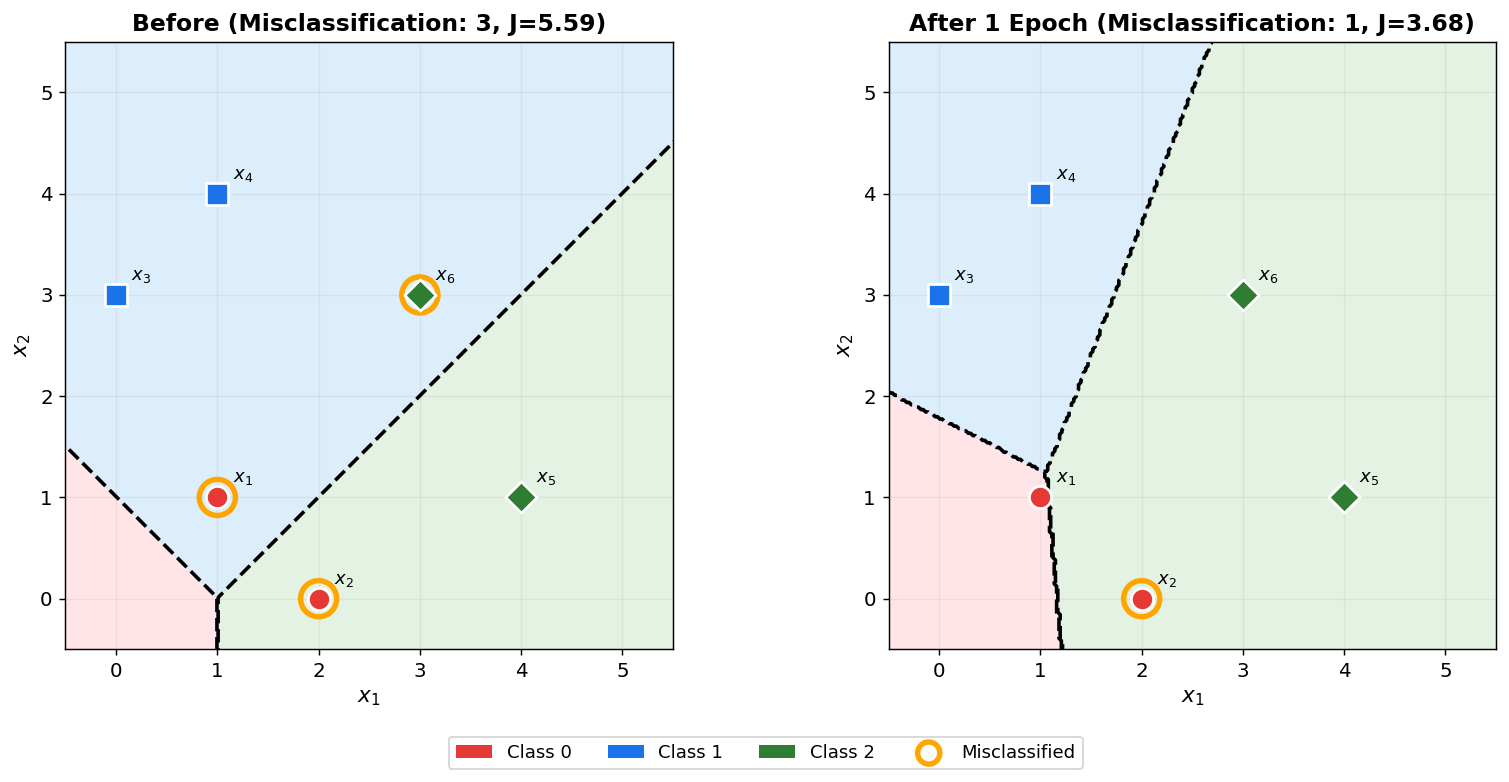

In [15]:
def plot_decision_regions(ax, W_plot, X_raw, y, title, show_labels=True):
    """결정 영역 + 경계 시각화"""
    # 결정 영역 (meshgrid)
    x1_range = np.linspace(-1, 6, 300)
    x2_range = np.linspace(-1, 6, 300)
    xx1, xx2 = np.meshgrid(x1_range, x2_range)
    X_mesh = np.column_stack([np.ones(xx1.size), xx1.ravel(), xx2.ravel()])
    Z_mesh = X_mesh @ W_plot.T
    O_mesh = softmax(Z_mesh)
    pred_mesh = np.argmax(O_mesh, axis=1).reshape(xx1.shape)
    
    # 영역 색상
    from matplotlib.colors import ListedColormap
    cmap_bg = ListedColormap(['mistyrose', 'lavender', 'honeydew'])
    ax.contourf(xx1, xx2, pred_mesh, levels=[-0.5, 0.5, 1.5, 2.5],
                cmap=cmap_bg, alpha=0.5)
    
    # 경계선 (contour)
    ax.contour(xx1, xx2, pred_mesh, levels=[0.5, 1.5], colors='black',
               linewidths=2, linestyles='--')
    
    # 데이터 포인트
    for k in range(C):
        mask = y == k
        ax.scatter(X_raw[mask, 0], X_raw[mask, 1], c=COLORS[k], marker=MARKERS[k],
                   s=150, edgecolors='white', linewidth=1.5, zorder=5)
    
    # 오분류 표시
    X_aug = np.column_stack([np.ones(len(y)), X_raw])
    Z_pts = X_aug @ W_plot.T
    preds_pts = np.argmax(softmax(Z_pts), axis=1)
    for n in range(len(y)):
        if preds_pts[n] != y[n]:
            ax.scatter(X_raw[n,0], X_raw[n,1], s=400, facecolors='none',
                       edgecolors='orange', linewidths=3, zorder=4)
    
    # 라벨
    if show_labels:
        for n in range(len(y)):
            ax.annotate(f'$x_{n+1}$', (X_raw[n,0]+0.15, X_raw[n,1]+0.15), fontsize=10, zorder=6)
    
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlim(-0.5, 5.5)
    ax.set_ylim(-0.5, 5.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.2)

# ── Before vs After ──
fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))

n_mis_b = np.sum(preds != y)
n_mis_a = np.sum(preds_new != y)

plot_decision_regions(axes[0], W, X_raw, y,
                      f'Before (Misclassification: {n_mis_b}, J={total_loss:.2f})')
plot_decision_regions(axes[1], W_new, X_raw, y,
                      f'After 1 Epoch (Misclassification: {n_mis_a}, J={total_loss_new:.2f})')

# Legend
legend_elements = [
    mpatches.Patch(facecolor=COLORS[0], label='Class 0'),
    mpatches.Patch(facecolor=COLORS[1], label='Class 1'),
    mpatches.Patch(facecolor=COLORS[2], label='Class 2'),
    plt.scatter([], [], s=150, facecolors='none', edgecolors='orange', linewidths=3, label='Misclassified'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=10,
           bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()

---
## Step 10: 다중 Epoch 학습 & 결정경계 변화

In [11]:
# ── Multi-epoch training ──
W_train = W.copy()
history = {'W': [W.copy()], 'J': [], 'mis': [], 'O': [O.copy()]}

n_epochs = 50

for epoch in range(n_epochs):
    Z_t = X @ W_train.T
    O_t = softmax(Z_t)
    
    # Loss
    loss = -np.sum(np.log(O_t[np.arange(N), y] + 1e-15))
    mis = np.sum(np.argmax(O_t, axis=1) != y)
    
    history['J'].append(loss)
    history['mis'].append(mis)
    
    # Gradient & Update
    E_t = O_t - Y_oh
    dW_t = E_t.T @ X
    W_train = W_train - rho * dW_t
    
    history['W'].append(W_train.copy())
    history['O'].append(softmax(X @ W_train.T))

# 최종 결과
print(f"학습 완료 ({n_epochs} epochs)")
print(f"  J: {history['J'][0]:.4f} → {history['J'][-1]:.4f}")
print(f"  오분류: {history['mis'][0]}개 → {history['mis'][-1]}개")

학습 완료 (50 epochs)
  J: 5.5852 → 0.5420
  오분류: 3개 → 0개


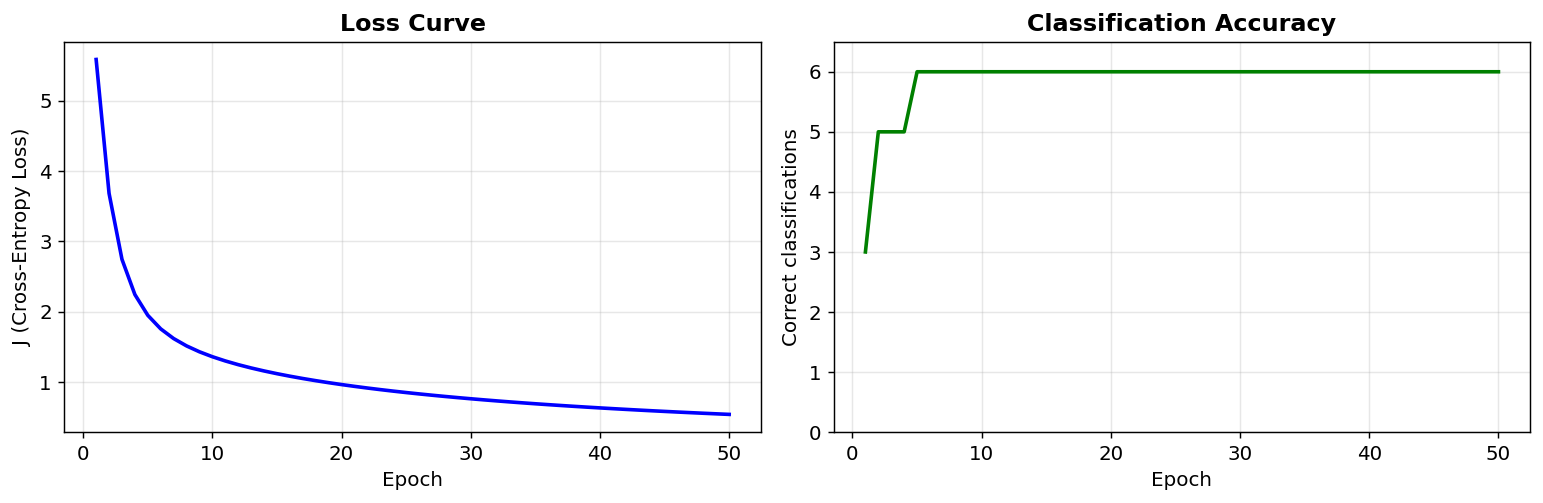

In [12]:
# ── Loss & Accuracy curve ──
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, n_epochs+1), history['J'], 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('J (Cross-Entropy Loss)')
axes[0].set_title('Loss Curve', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, n_epochs+1), [N-m for m in history['mis']], 'g-', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Correct classifications')
axes[1].set_title('Classification Accuracy', fontweight='bold')
axes[1].set_ylim(0, N+0.5)
axes[1].set_yticks(range(N+1))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

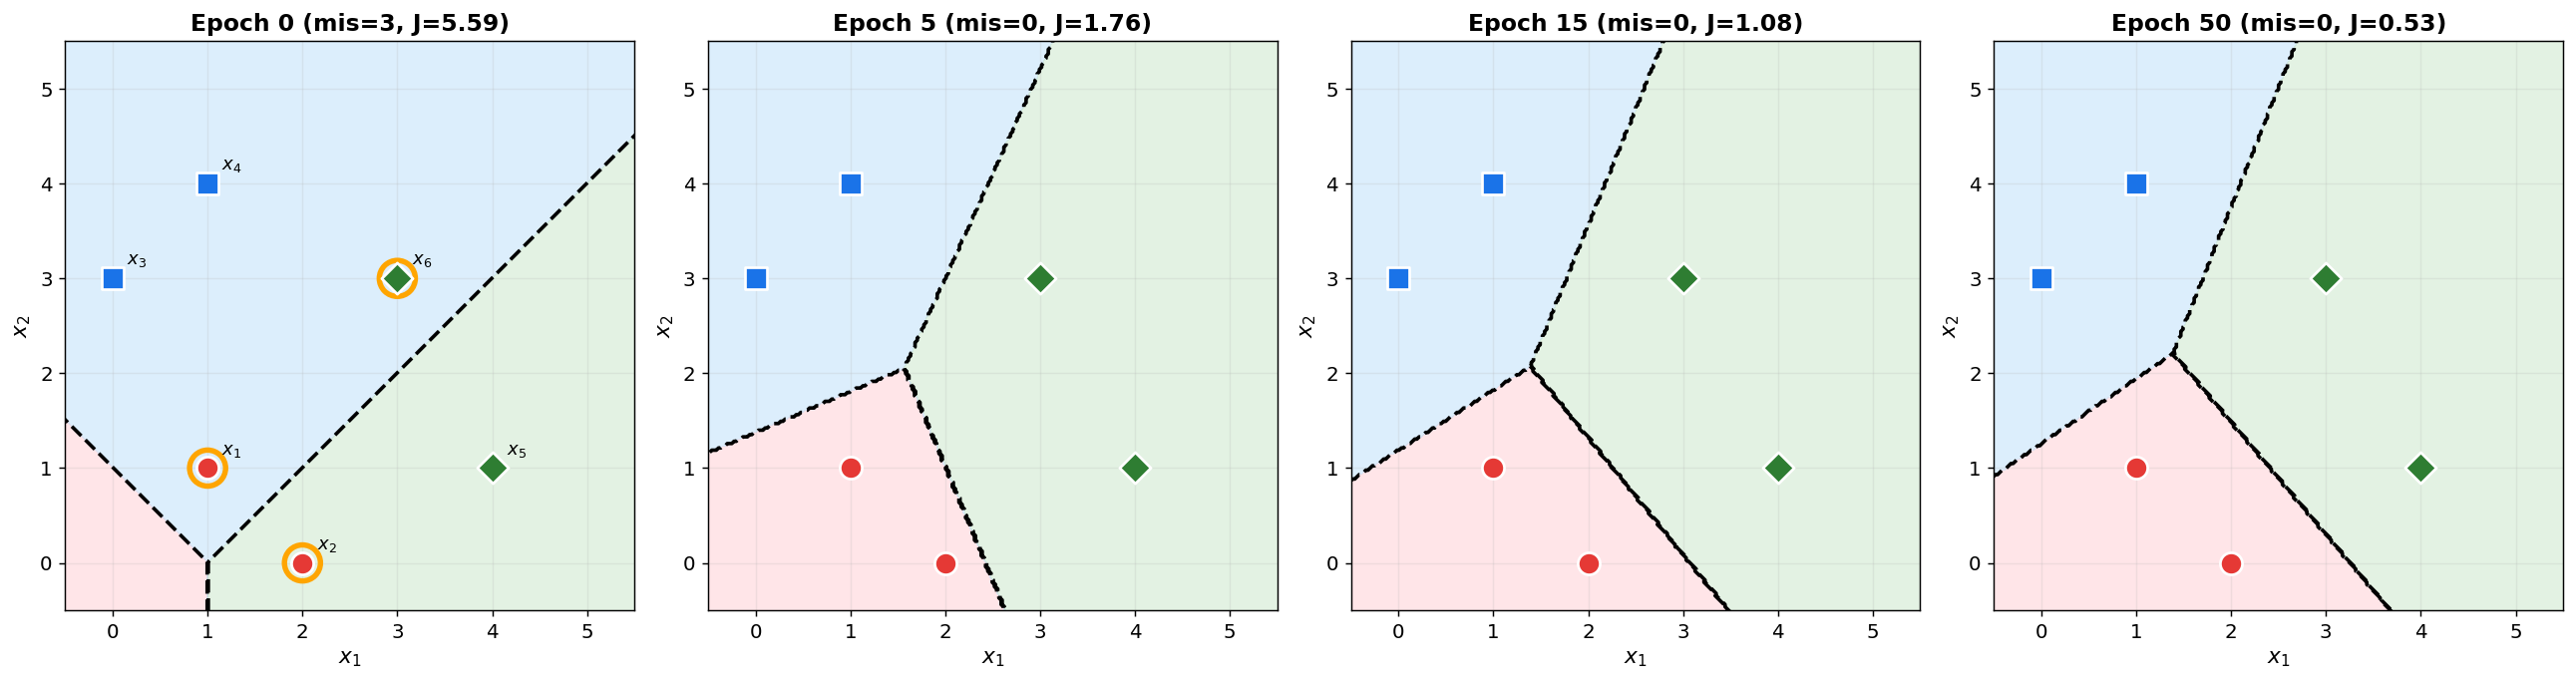

In [13]:
# ── 결정경계 변화 (epoch 0, 5, 15, 50) ──
snapshots = [0, 5, 15, n_epochs]
fig, axes = plt.subplots(1, len(snapshots), figsize=(5*len(snapshots), 5))

for i, ep in enumerate(snapshots):
    W_snap = history['W'][ep]
    Z_snap = X @ W_snap.T
    O_snap = softmax(Z_snap)
    mis = np.sum(np.argmax(O_snap, axis=1) != y)
    loss = -np.sum(np.log(O_snap[np.arange(N), y] + 1e-15))
    
    plot_decision_regions(axes[i], W_snap, X_raw, y,
                          f'Epoch {ep} (mis={mis}, J={loss:.2f})',
                          show_labels=(i==0))

plt.tight_layout()
plt.show()

---
## 핵심 정리

| Binary 로지스틱 회귀 | Multi-class 로지스틱 회귀 |
|:---|:---|
| 활성함수: sigmoid $\sigma(z)$ | 활성함수: softmax $o_k$ |
| 가중치: $\mathbf{w}$ 벡터 1개 | 가중치: $\mathbf{W}$ 행렬 ($C \times (d+1)$) |
| 결정경계: 직선 1개 | 결정경계: 쌍별 직선 $C(C-1)/2$개 |
| 그래디언트: $(\sigma - y)x_i$ | 그래디언트: $(o_k - y_k)x_i$ |
| 매트릭스: $\nabla J = \mathbf{X}^T(\boldsymbol{\sigma} - \mathbf{y})$ | 매트릭스: $\nabla J = (\mathbf{O}-\mathbf{Y})^T\mathbf{X}$ |
| **동일한 형태!** 활성함수와 가중치 구조만 다름 ||